# 这个文件处理：

1. 简单查看scalar.txt的量：1.电磁场； 2. 质子动能；

2. 重点算particle binning的数据，从而得出A（温度各向异性）

3. 分析MS波和EMIC波的波形特点，空间波数

In [ ]:
# numerics
import numpy as np
import math as m
import scipy
from scipy.fftpack import fft,ifft,fftshift,fft2
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
from scipy import signal
pi = m.pi

# plot
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.gridspec import GridSpec
from matplotlib.patches import FancyArrowPatch, ArrowStyle
import matplotlib.patches as patches
from wav_analysis.add_cb import add_color_bar_V
from cmap import purula

# others
import os
import happi
import h5py

plt.style.use("paper")

In [2]:
path = os.getcwd()

# Open a Scalar diagnostic
S = happi.Open(path)

Loaded simulation '/media/ustcxp/C14D581BDA18EBFA/research/MS_wave/para_MS/ns/20ns'
Scanning for Scalar diagnostics
Scanning for Field diagnostics
Scanning for Probe diagnostics
Scanning for ParticleBinning diagnostics
Scanning for RadiationSpectrum diagnostics
Scanning for Performance diagnostics
Scanning for Screen diagnostics
Scanning for Tracked particle diagnostics


In [ ]:
# basic parameters
me = 1.
e = 1.
mp = 100 * me
c = 1
# -> wpe = 1

wpp = 1./np.sqrt(mp)  # proton plasma frequency
v_ratio = 15.         # c/vA
wcp = wpp/v_ratio     # cyclotron frequency
B0 = wcp*mp/e         # magnetic field magnitude

vA = c/v_ratio        # proton Afven speed
vbth = 0.03*vA        # background proton thermal velocity
vsth = 0.45*vA        # shell dist. proton thermal velocity
dt = 0.001            # simualtion time step, in wcp^-1

#使用初始背景磁场的大小来初步验证模拟结果
init_Bx = B0                     # B0 is on x axis
lambda_p = c/wpp             # characteristc length (proton inertial length)

# simulation length & grid 
Lx = 102.4*lambda_p         
Ly = 12.8*lambda_p
Nx = 512
Ny = 128
dx = Lx/Nx
dy = Ly/Ny

#setting grid
#空间上的单位是lambda_i
dx_norm = dx/lambda_p
dy_norm = dy/lambda_p
x = np.linspace(0,Nx,Nx+1)
y = np.linspace(0,Ny,Ny+1)

X,Y = np.meshgrid(x.astype(int),y.astype(int))


# 读取scalar.txt中的Bx, 计算初始磁场总能量来进行验算
UBx = S.Scalar('Uelm_Bx_m').getData()
Utot = S.Scalar('Utot').getData()
init_U = Utot[0]

# integrate 
init_UB = 0.5 * init_Bx**2 * dx * dy * (Nx+1) * (Ny+2)

print('Uelm_Bx_m[t=0] = ', {UBx[0]})
print('integrate inital UB = ', {init_UB})

In [ ]:
# 读取scalar.txt中的By, Bz, Ex, Ey, Ez, Ukin_shell_ion, Ukin_cold_ion

wcp_unit = '$\Omega_{cp}$'
# every_field0 = 50
Bx = np.array(S.Field(0,'Bx').getData())
field0_t = np.array(S.Field(0,'Bx').getTimes())

# unit transfer to \Omega_cp
# field0_t * wcp

# every_field1 = 500
UBy = S.Scalar('Uelm_By_m').getData()/init_UB
UBz = S.Scalar('Uelm_Bz_m').getData()/init_UB

UEx = S.Scalar('Uelm_Ex').getData()/(c**2*init_UB)
UEy = S.Scalar('Uelm_Ey').getData()/(c**2*init_UB)
UEz = S.Scalar('Uelm_Ez').getData()/(c**2*init_UB)
field1_t = np.array(S.Scalar('Uelm_By_m').getTimes())


# particles energy
Ukin_shell_ion = S.Scalar('Ukin_shell_ion').getData()
Ukin_cold_ion = S.Scalar('Ukin_cold_ion').getData()


# 单独计算 \delta Bx
# UBx
UBx = np.zeros(len(field0_t))
delta_Bx = Bx - B0        

for i in range(len(field0_t)):
    UBx[i] = np.sum(0.5 * np.power(delta_Bx[i,:,:],2)*dx*dy)
UBx /= init_UB

# 1. Scalar

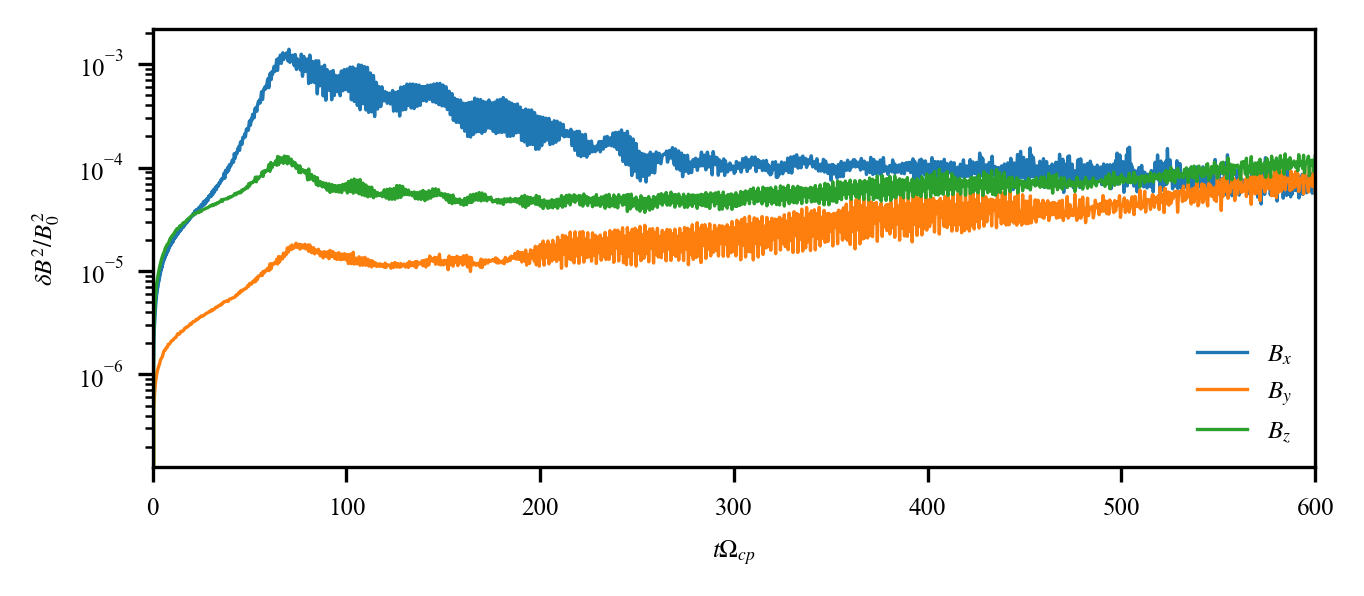

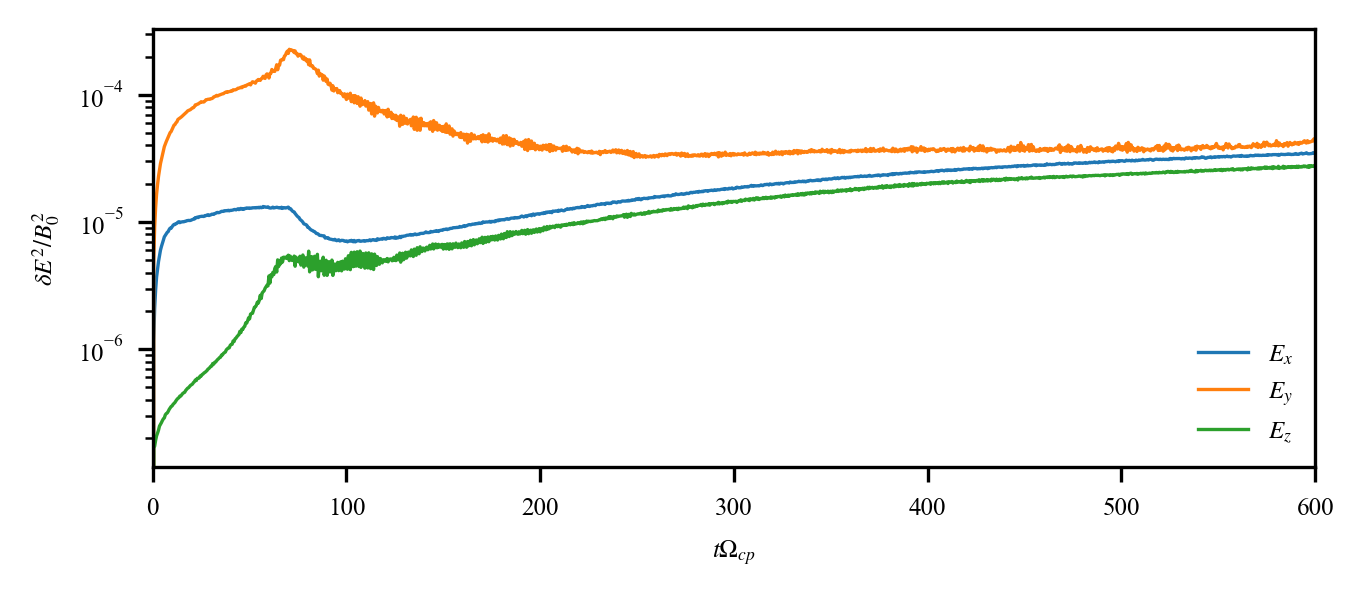

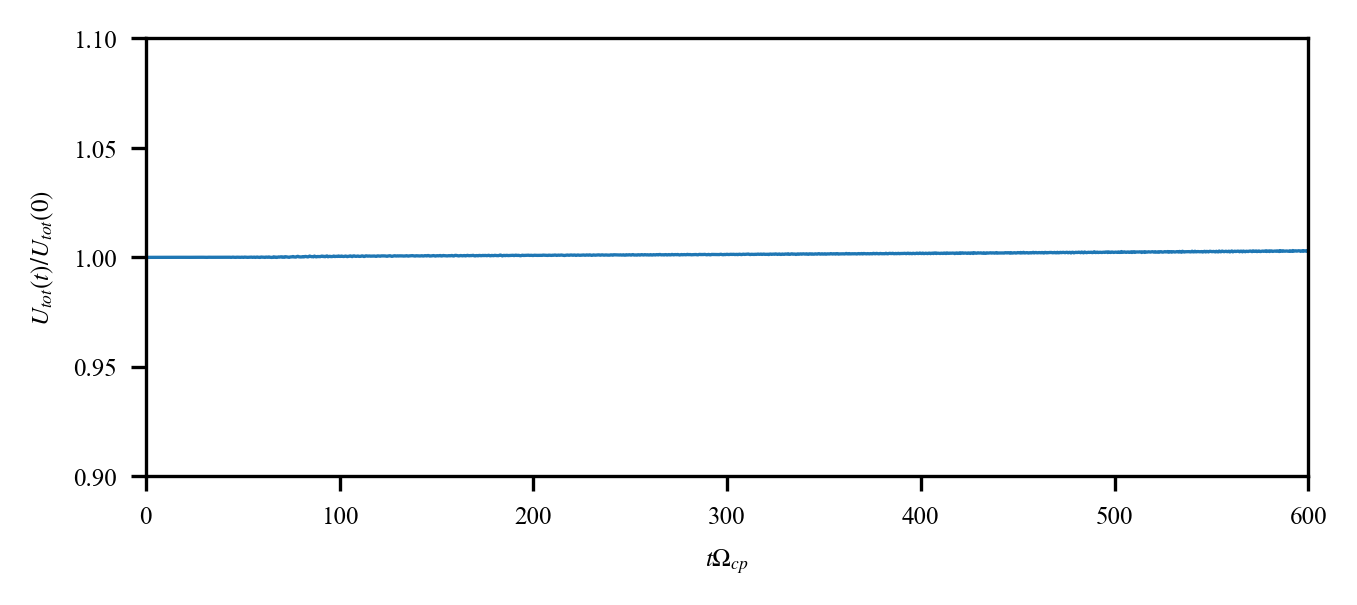

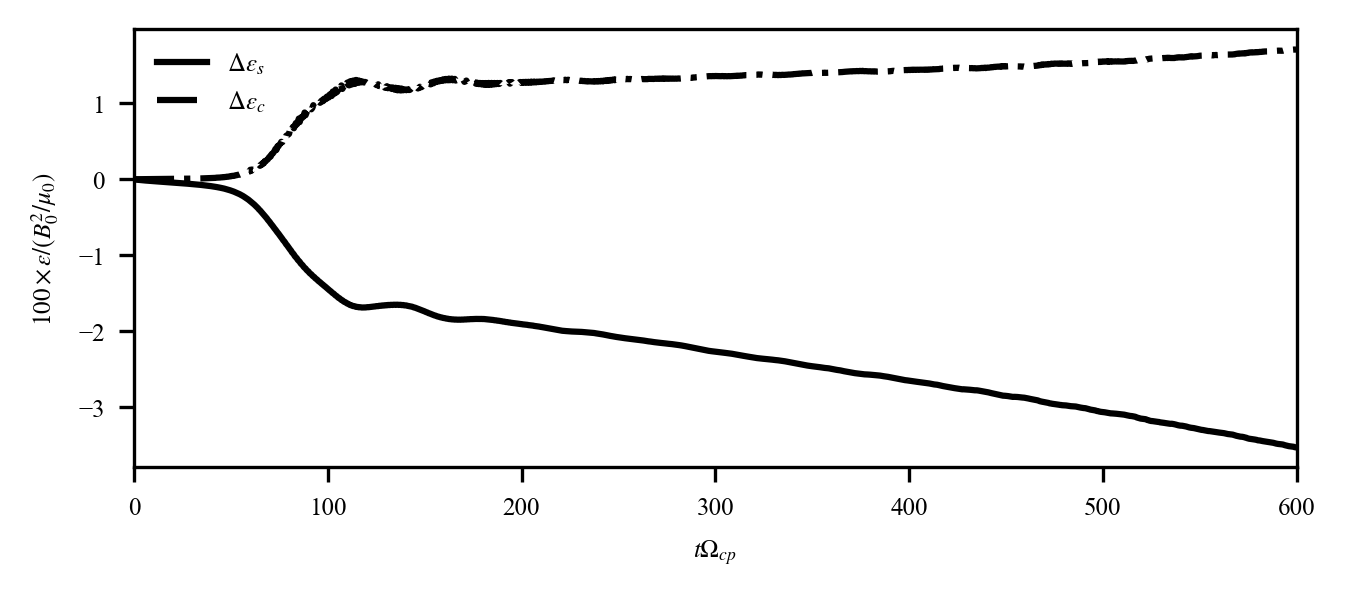

In [7]:
plt.close()
fig,ax=plt.subplots(figsize=[5,2])
ax.plot(field0_t*wcp,UBx,lw=0.8,label='$B_x$')
ax.plot(field1_t*wcp,UBy,lw=0.8,label='$B_y$')
ax.plot(field1_t*wcp,UBz,lw=0.8,label='$B_z$')
ax.set_yscale('log')
ax.set_xlim(0, 600)
ax.set_xlabel('$t$'+wcp_unit)
ax.set_ylabel('$\delta B^2/B_0^2$')
ax.legend()
plt.show()

plt.close()
fig,ax=plt.subplots(figsize=[5,2])
ax.plot(field1_t*wcp,UEx,lw=0.8,label='$E_x$')
ax.plot(field1_t*wcp,UEy,lw=0.8,label='$E_y$')
ax.plot(field1_t*wcp,UEz,lw=0.8,label='$E_z$')
ax.set_yscale('log')
ax.set_xlim(0, 600)
ax.set_xlabel('$t$'+wcp_unit)
ax.set_ylabel('$\delta E^2/B_0^2$')
ax.legend()
plt.show()

plt.close()
fig,ax=plt.subplots(figsize=[5,2])
ax.plot(field1_t*wcp,Utot/init_U,lw=0.8)
ax.set_xlim(0, 600)
ax.set_ylim(0.9,1.1)
ax.set_xlabel('$t$'+wcp_unit)
ax.set_ylabel('$U_{tot}(t)/U_{tot}(0)$')
plt.show()

plt.close()
fig,ax=plt.subplots(figsize=[5,2])
ax.plot(field1_t*wcp, 100*(Ukin_shell_ion-Ukin_shell_ion[0])/init_UB, color='black',lw=1.5,label='$\Delta \epsilon_{s}$')
ax.plot(field1_t*wcp, 100*(Ukin_cold_ion-Ukin_cold_ion[0])/init_UB, color='black',lw=1.5,linestyle= '-.',label='$\Delta \epsilon_{c}$')
ax.set_xlim(0, 600)
ax.set_xlabel('$t$'+wcp_unit)
ax.set_ylabel(r'$100 \times \epsilon/(B_0^2/ \mu_0)$')
ax.legend()
plt.show()

In [10]:
with h5py.File('./data/ns20.h5','a') as f:
    f.create_dataset('field0_t', data=field0_t)
    f.create_dataset('field1_t', data=field1_t)
    f.create_dataset('UBx', data=UBx)
    f.create_dataset('UBy', data=UBy)
    f.create_dataset('UBz', data=UBz)
    f.create_dataset('UEx', data=UEx)
    f.create_dataset('UEy', data=UEy)
    f.create_dataset('UEz', data=UEz)
    f.create_dataset('Ukin_shell_ion ', data=Ukin_shell_ion)
    f.create_dataset('Ukin_cold_ion ', data=Ukin_cold_ion)

del UBx,UBy,UBz,UEx,UEy,UEz,Utot,Ukin_cold_ion,Ukin_shell_ion

# 2. Particle Binning

In [11]:
T0 = mp*vbth**2

Pxx_c = np.array(S.ParticleBinning(0).getData())
Pyy_c = np.array(S.ParticleBinning(1).getData())
Pzz_c = np.array(S.ParticleBinning(2).getData())
ntot_c = np.array(S.ParticleBinning(3).getData())

Pxx_s = np.array(S.ParticleBinning(4).getData())
Pyy_s = np.array(S.ParticleBinning(5).getData())
Pzz_s = np.array(S.ParticleBinning(6).getData())
ntot_s = np.array(S.ParticleBinning(7).getData())

Pxx_e = np.array(S.ParticleBinning(8).getData())
Pyy_e = np.array(S.ParticleBinning(9).getData())
Pzz_e = np.array(S.ParticleBinning(10).getData())
ntot_e = np.array(S.ParticleBinning(11).getData())

binning_t = np.array(S.ParticleBinning(11).getTimes())

Tpa_c = Pxx_c/ntot_c / T0
Tpa_s = Pxx_s/ntot_s / T0
Tpa_e = Pxx_e/ntot_e / T0

Tpe_c = (Pyy_c+Pzz_c)/ntot_c/2 / T0 
Tpe_s = (Pyy_s+Pzz_s)/ntot_s/2 / T0 
Tpe_e = (Pyy_e+Pzz_e)/ntot_e/2 / T0 

A_c = Tpe_c/Tpa_c - 1
A_s = Tpe_s/Tpa_s - 1
A_e = Tpe_e/Tpa_e - 1

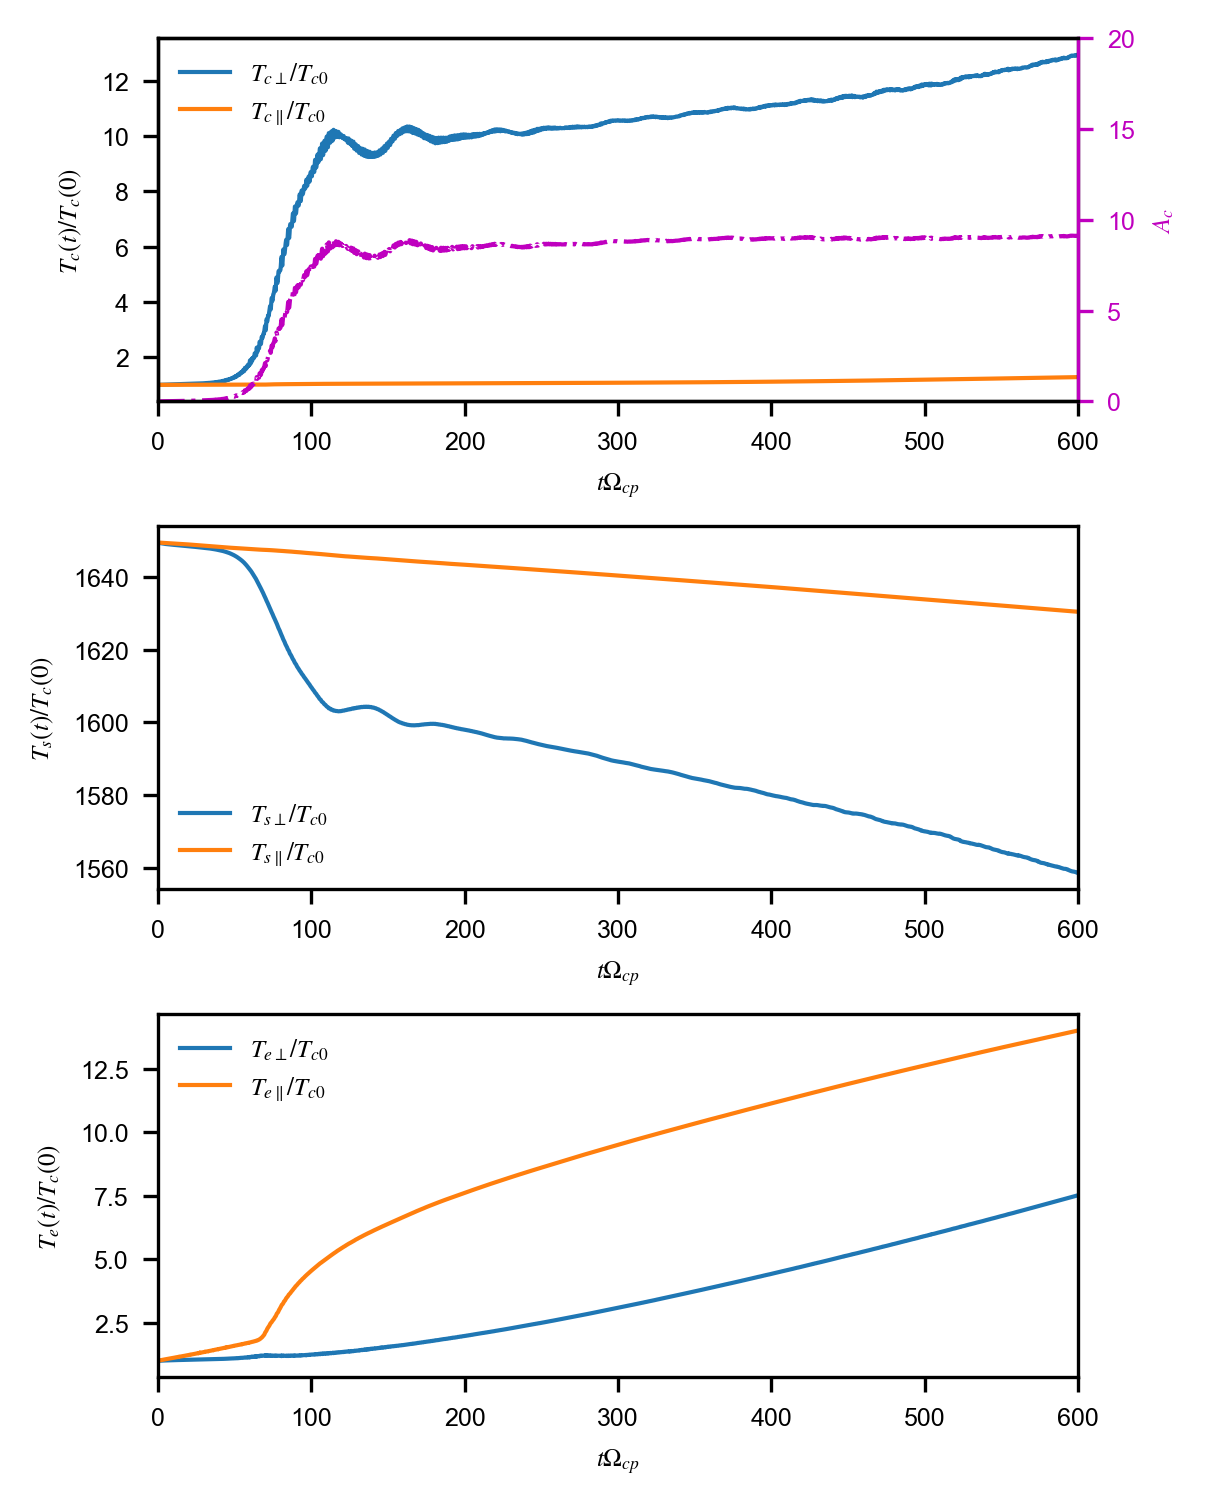

In [ ]:
plt.close()
fig,axs = plt.subplots(3,1,figsize=[4,5])
axs[0].plot(binning_t*wcp,Tpe_c,label=r"$T_{c \perp}/T_{c0}$")
axs[0].plot(binning_t*wcp,Tpa_c,label=r"$T_{c \parallel}/T_{c0}$")
axs[0].set_ylabel('$T_c(t)/T_c(0)$')
tx = axs[0].twinx()
tx.plot(binning_t*wcp,A_c,c='m',ls='-.')
tx.set_ylabel('$A_c$',color='m')
tx.set_ylim(0,20)
tx.tick_params(axis='y',colors='m')
tx.spines['right'].set_color('m')
axs[0].legend(loc=2)

axs[1].plot(binning_t*wcp,Tpe_s,label=r"$T_{s \perp}/T_{c0}$")
axs[1].plot(binning_t*wcp,Tpa_s,label=r"$T_{s \parallel}/T_{c0}$")
axs[1].set_ylabel('$T_s(t)/T_c(0)$')
axs[1].legend()

axs[2].plot(binning_t*wcp,Tpe_e,label=r"$T_{e \perp}/T_{c0}$")
axs[2].plot(binning_t*wcp,Tpa_e,label=r"$T_{e \parallel}/T_{c0}$")
axs[2].set_ylabel('$T_e(t)/T_c(0)$')
axs[2].legend()

for i in range(3):
    axs[i].set_xlabel('$t$'+wcp_unit)
    axs[i].set_xlim(0,600)

plt.tight_layout()

Ac_max_index = np.argmax(A_c)
Ac_max_time = Ac_max_index*wcp
Ac_max = A_c[Ac_max_index]
print(Ac_max_time)
print(Ac_max)

In [13]:
with h5py.File('./data/ns20.h5','a') as f:
    f.create_dataset('binning_t', data=binning_t)
    f.create_dataset('Tpa_c', data=Tpa_c)
    f.create_dataset('Tpe_c', data=Tpe_c)
    f.create_dataset('A_c', data=A_c)

del Tpa_c,Tpa_s,Tpa_e,Tpe_c,Tpe_s,Tpe_e,A_c,A_s,A_e
del Pxx_c,Pxx_s,Pxx_e
del Pyy_c,Pyy_s,Pyy_e
del Pzz_c,Pzz_s,Pzz_e
del ntot_c,ntot_s,ntot_e

# 3. wave properties

In [14]:
# Bx and time have been read in scalar data processing
# read field0
By = np.array(S.Field(0,'By').getData())
Bz = np.array(S.Field(0,'Bz').getData())

## 3.1 MS waves

In [15]:
every_field0 = 50

# wave number
t_point = 40
t_point_idx = int(t_point/dt/every_field0)
bx_space = (Bx[t_point_idx,:,:] - B0)/B0
by_space = By[t_point_idx,:,:]/B0
bz_space = Bz[t_point_idx,:,:]/B0

#设置坐标轴（刻度），转换到（角）波数空间中
kx = np.fft.fftfreq(Nx+1,dx_norm)*2*pi
kx = np.fft.fftshift(kx)

ky = np.fft.fftfreq(Ny+1,dy_norm)*2*pi
ky = np.fft.fftshift(ky)

#数据的二维fft变换
fft2Bx = fft2(bx_space)
xpsd_space = np.transpose(np.fft.fftshift(np.real(fft2Bx*fft2Bx.conj())))

fft2By = fft2(by_space)
ypsd_space = np.transpose(np.fft.fftshift(np.real(fft2By*fft2By.conj())))

fft2Bz = fft2(bz_space)
zpsd_space = np.transpose(np.fft.fftshift(np.real(fft2Bz*fft2Bz.conj())))


# wave frequency
t_start = 0
t_end = 60

n_start = int(t_start/dt/every_field0) 
n_end = int(t_end/dt/every_field0)

t_select = field0_t[n_start:n_end]*wcp
bx = (Bx[n_start:n_end,:,:]-B0)/B0
by = By[n_start:n_end,:,:]/B0
bz = Bz[n_start:n_end,:,:]/B0

bx -= np.mean(bx, axis=(1,2), keepdims=True)
by -= np.mean(by, axis=(1,2), keepdims=True)
bz -= np.mean(bz, axis=(1,2), keepdims=True)

# Number of sample points
N = len(t_select)
#sample spacing
DT = t_select[1] - t_select[0]
fs = 1/DT
MS_freq = fftfreq(N, DT)[:N//2]*2*np.pi

bx_f = fft(bx, axis=0)
bx_f_avg = np.mean(np.abs(bx_f)**2, axis=(1,2))
xpsd = (2 / (N * fs)) * bx_f_avg[:N//2]

by_f = fft(by, axis=0)
by_f_avg = np.mean(np.abs(by_f)**2, axis=(1,2))
ypsd = (2 / (N * fs)) * by_f_avg[:N//2]

bz_f = fft(bz, axis=0)
bz_f_avg = np.mean(np.abs(bz_f)**2, axis=(1,2))
zpsd = (2 / (N * fs)) * bz_f_avg[:N//2]

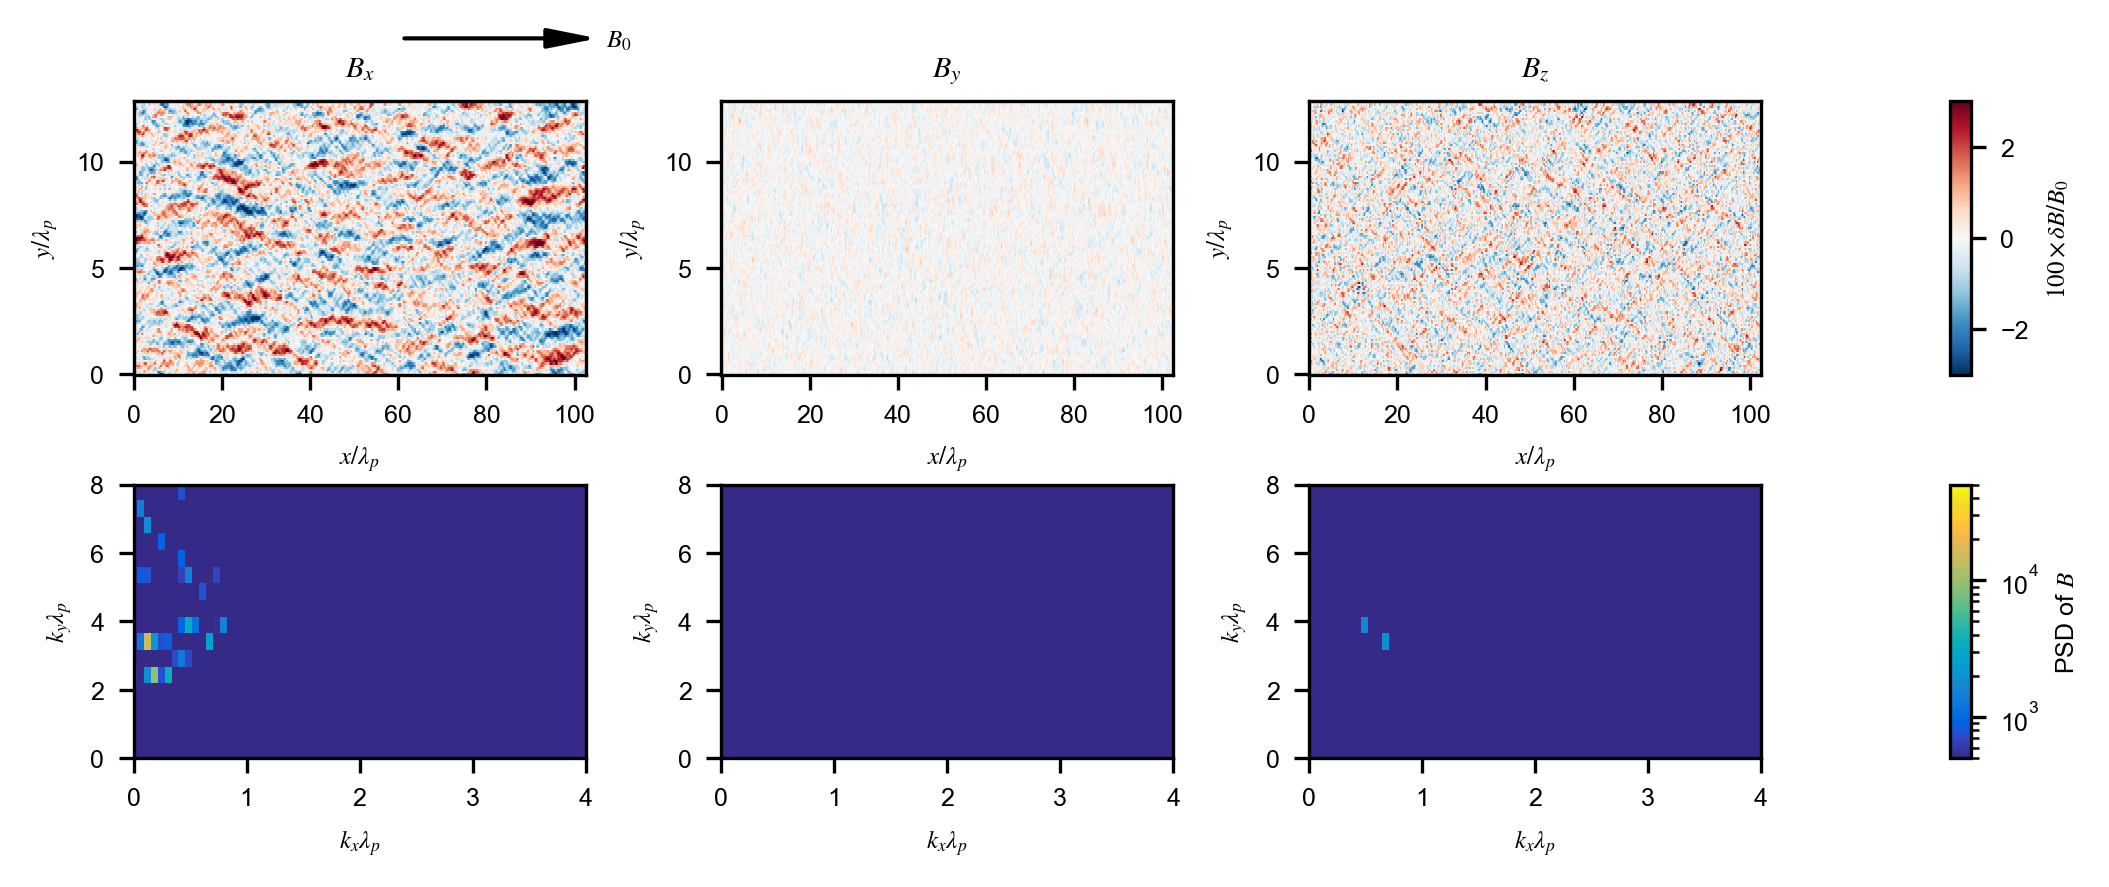

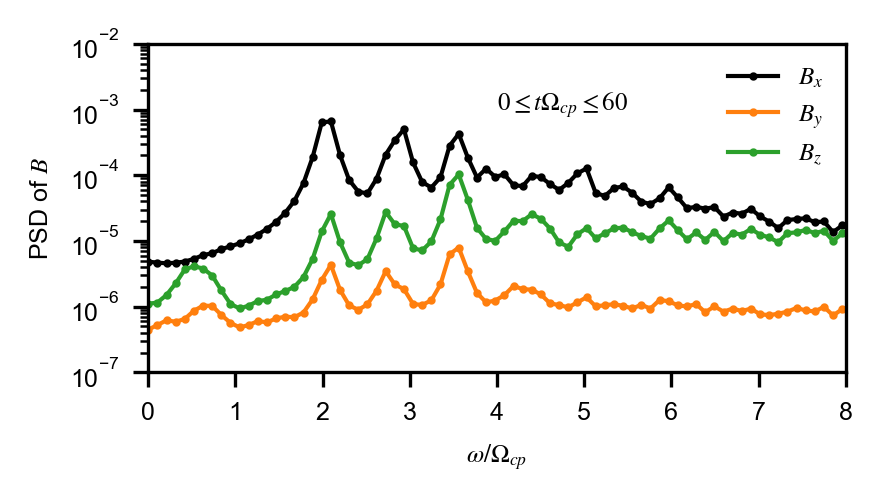

In [16]:
scale = 100
plt.close()
fig,axs = plt.subplots(2,3,figsize=[7, 3])
plt.subplots_adjust(wspace=0.3, hspace=0.4)  
# 箭头
# fig.suptitle("$t\Omega_{cp}=40$")
style = ArrowStyle('-|>', head_length=0.5, head_width=0.1)
arrow = FancyArrowPatch((0.25, 0.95), (0.35, 0.95),
                        arrowstyle=style,
                        clip_on=False,
                        mutation_scale=20,  # 控制箭头大小
                        color='black',
                        transform=fig.transFigure)  # 箭头颜色
# 将箭头添加到整个图上
fig.patches.append(arrow)
fig.text(0.35, 0.94,'$B_0$', color='black')

pcm0 = axs[0,0].pcolormesh(X*dx_norm, Y*dy_norm, scale*bx_space[:,:].T, cmap='RdBu_r', vmin=-3, vmax=3,rasterized=True)
pcm1 = axs[0,1].pcolormesh(X*dx_norm, Y*dy_norm, scale*by_space[:,:].T, cmap='RdBu_r', vmin=-3, vmax=3,rasterized=True)
pcm2 = axs[0,2].pcolormesh(X*dx_norm, Y*dy_norm, scale*bz_space[:,:].T, cmap='RdBu_r', vmin=-3, vmax=3,rasterized=True)
add_color_bar_V(pcm2, axs[0,2], fig, 
                width = 0.01,
                wspace = 0.09,
                label=r'$100 \times \delta B / B_0$', position='right')

axs[0,0].set_title('$B_x$')
axs[0,1].set_title('$B_y$')
axs[0,2].set_title('$B_z$')
for i in range(3):
    axs[0,i].set_xlabel('$x/\lambda_p$')
    axs[0,i].set_ylabel('$y/\lambda_p$')

pcm0 = axs[1,0].pcolormesh(kx, ky, xpsd_space, cmap=purula(), norm='log', vmin=5e2, vmax=5e4, rasterized=True)
pcm1 = axs[1,1].pcolormesh(kx, ky, ypsd_space, cmap=purula(), norm='log', vmin=5e2, vmax=5e4, rasterized=True)
pcm2 = axs[1,2].pcolormesh(kx, ky, zpsd_space, cmap=purula(), norm='log', vmin=5e2, vmax=5e4, rasterized=True)
add_color_bar_V(pcm2, axs[1,2], fig, 
                width = 0.01,
                wspace = 0.09,
                label=r'PSD of $B$', position='right')

for i in range(3):
    axs[1,i].set_xlim(0, (1/dx_norm)-1)
    axs[1,i].set_ylim(0, (1/dy_norm)-2)
    axs[1,i].set_xlabel('$k_x \lambda_p$')
    axs[1,i].set_ylabel('$k_y \lambda_p$')
# plt.tight_layout()
plt.show()

plt.close()
fig,ax = plt.subplots(figsize=[3, 1.5])
ax.set_yscale('log')
ax.plot(MS_freq, xpsd, 'o-', c='black',  label='$B_x$', ms=1)
ax.plot(MS_freq, ypsd, 'o-', c='C1',  label='$B_y$', ms=1)
ax.plot(MS_freq, zpsd, 'o-', c='C2',  label='$B_z$', ms=1)
ax.set_xlim(0,8)
ax.set_ylim(1e-7, 1e-2)
ax.set_xlabel('$\omega/\Omega_{cp}$')
ax.set_ylabel('PSD of $B$')
ax.text(4,1e-3,'$0 \leq t\Omega_{cp} \leq 60$')
ax.legend()
plt.show()

In [17]:
with h5py.File('./data/ns20.h5','a') as f:
    f.create_dataset('Bx', data=Bx)
    f.create_dataset('By', data=By)
    f.create_dataset('Bz', data=Bz)

del bx_space,by_space,bz_space
del xpsd_space,ypsd_space,zpsd_space
del bx,by,bz
del xpsd, ypsd, zpsd

## 3.2 EMIC waves

In [ ]:
every_field0 = 50

# wave number
t_point = 300
t_point_idx = int(t_point/dt/every_field0)
bx_space = (Bx[t_point_idx,:,:] - B0)/B0
by_space = By[t_point_idx,:,:]/B0
bz_space = Bz[t_point_idx,:,:]/B0

# #设置坐标轴（刻度），转换到（角）波数空间中
# kx = np.fft.fftfreq(Nx+1,dx_norm)*2*pi
# kx = np.fft.fftshift(kx)

# ky = np.fft.fftfreq(Ny+1,dy_norm)*2*pi
# ky = np.fft.fftshift(ky)

#数据的二维fft变换
fft2Bx = fft2(bx_space)
xpsd_space = np.transpose(np.fft.fftshift(np.real(fft2Bx*fft2Bx.conj())))

fft2By = fft2(by_space)
ypsd_space = np.transpose(np.fft.fftshift(np.real(fft2By*fft2By.conj())))

fft2Bz = fft2(bz_space)
zpsd_space = np.transpose(np.fft.fftshift(np.real(fft2Bz*fft2Bz.conj())))


# wave frequency
t_start = 100
t_end = 600

n_start = int(t_start/dt/every_field0) 
n_end = int(t_end/dt/every_field0)

t_select = field0_t[n_start:n_end]*wcp
bx = (Bx[n_start:n_end,:,:]-B0)/B0
by = By[n_start:n_end,:,:]/B0
bz = Bz[n_start:n_end,:,:]/B0

bx -= np.mean(bx, axis=(1,2), keepdims=True)
by -= np.mean(by, axis=(1,2), keepdims=True)
bz -= np.mean(bz, axis=(1,2), keepdims=True)

# Number of sample points
N = len(t_select)
#sample spacing
DT = t_select[1] - t_select[0]
fs = 1/DT
MS_freq = fftfreq(N, DT)[:N//2]*2*np.pi

bx_f = fft(bx, axis=0)
bx_f_avg = np.mean(np.abs(bx_f)**2, axis=(1,2))
xpsd = (2 / (N * fs)) * bx_f_avg[:N//2]

by_f = fft(by, axis=0)
by_f_avg = np.mean(np.abs(by_f)**2, axis=(1,2))
ypsd = (2 / (N * fs)) * by_f_avg[:N//2]

bz_f = fft(bz, axis=0)
bz_f_avg = np.mean(np.abs(bz_f)**2, axis=(1,2))
zpsd = (2 / (N * fs)) * bz_f_avg[:N//2]